阶段 1: 环境设置、数据加载与初步预处理

数据加载成功:
<xarray.Dataset> Size: 378MB
Dimensions:    (time: 91, longitude: 1440, latitude: 721)
Coordinates:
  * time       (time) datetime64[ns] 728B 2020-01-01 2020-01-02 ... 2020-03-31
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Data variables:
    sst        (time, latitude, longitude) float32 378MB ...

原始SST数据形状: (91, 721, 1440)
纬度从北向南排列。裁剪最后一个纬度。
裁剪后的SST数据形状: (91, 720, 1440)
裁剪后数据中NaN值占比: 33.80%

--- 5. 数据归一化 (仅使用训练数据计算min/max) ---
用于计算归一化参数的训练数据时间范围索引 (0-indexed): 0 到 87
从选定的训练数据时间范围中计算得到的 SST最小值 (忽略NaN): 269.48
从选定的训练数据时间范围中计算得到的 SST最大值 (忽略NaN): 306.92
归一化后数据中NaN值占比: 33.80% (应与裁剪后相同)
归一化后SST数据的最小值 (忽略NaN): -1.00
归一化后SST数据的最大值 (忽略NaN): 1.00

总时间步数: 91
输入序列长度: 30
可生成的 (输入序列, 目标日) 对的数量: 61

归一化参数: {'min': np.float32(269.4762), 'max': np.float32(306.92264)}


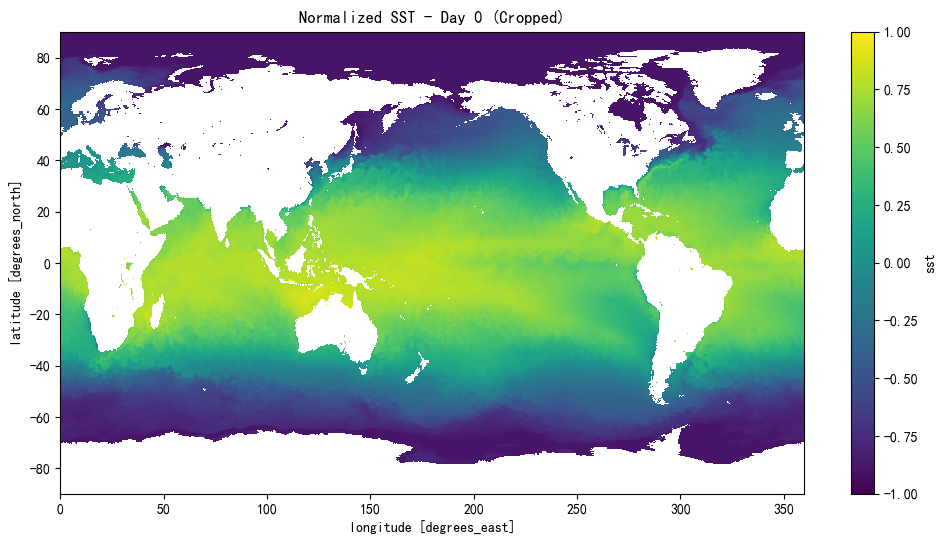

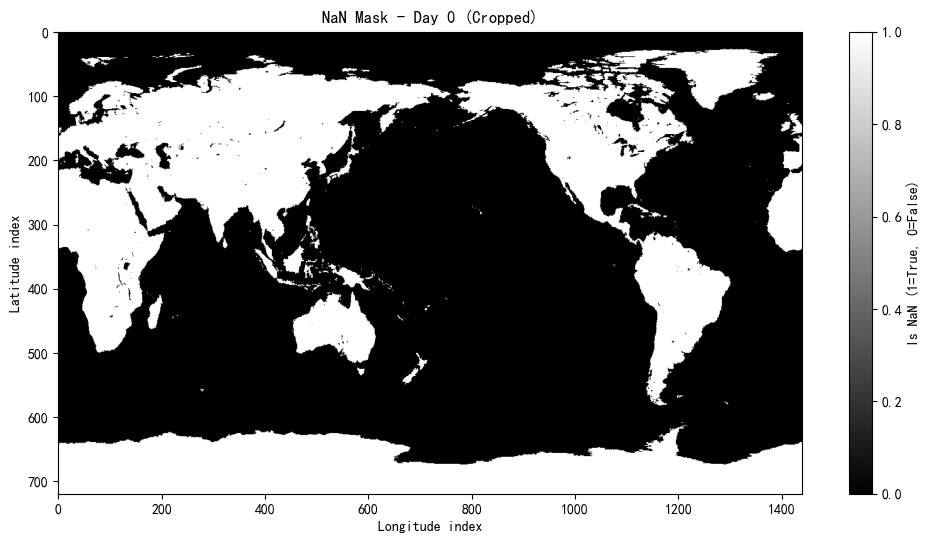

In [49]:
import xarray as xr
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from diffusers import UNet2DModel, DDPMScheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
from pathlib import Path

# --- 配置参数 ---
SEQUENCE_LEN = 30 # 输入序列长度为30天
TARGET_LEN = 1 # 目标长度为1天
NUM_TEST_TARGET_DAYS = 3 # 最后3天的目标用于测试


DATA_FILE_PATH = "..\\data\\processed\\ERA5\\ERA5_20200101_20200331.nc" 

# 1. 加载 .nc 数据集
try:
    raw_ds = xr.open_dataset(DATA_FILE_PATH)
    print("数据加载成功:")
    print(raw_ds)
except FileNotFoundError:
    print(f"错误: 文件 '{DATA_FILE_PATH}' 未找到。请确保路径正确。")
    raise SystemExit("请解决文件路径问题后再继续。")


# 2. 提取SST数据，并确保数据类型为float32
variable_name = 'sst'

sst_data_array = raw_ds[variable_name].astype(np.float32)
print(f"\n原始SST数据形状: {sst_data_array.shape}") # 应为 (time: 91, latitude: 721, longitude: 1440)

# 3. 纬度裁剪: 去除最南端，使纬度变为720
#    我们假设纬度是从北到南排列的 (e.g., 90, 89.75, ..., -90)
#    或者从南到北 (e.g., -90, -89.75, ..., 90)
#    我们需要确保裁剪掉的是南极大陆对应的纬度。
#    如果 latitude[0] > latitude[-1]，则是从北到南。去除最后一个纬度 slice(None, -1) 或 slice(0, 720)
#    如果 latitude[0] < latitude[-1]，则是从南到北。去除第一个纬度 slice(1, None) 或 slice(1, 721)

lat_coords = sst_data_array.coords['latitude']
if lat_coords[0] > lat_coords[-1]:
    print("纬度从北向南排列。裁剪最后一个纬度。")
    sst_cropped = sst_data_array.isel(latitude=slice(0, 720))
else:
    print("纬度从南向北排列。裁剪第一个纬度。")
    sst_cropped = sst_data_array.isel(latitude=slice(1, 721))

print(f"裁剪后的SST数据形状: {sst_cropped.shape}") # 应为 (time: 91, latitude: 720, longitude: 1440)

# 4. (初步) 处理NaN值：暂时保持原样，后续在patching时处理。
#    但可以先统计一下NaN的比例。
nan_percentage = np.isnan(sst_cropped.values).mean() * 100
print(f"裁剪后数据中NaN值占比: {nan_percentage:.2f}%")

print("\n--- 5. 数据归一化 (仅使用训练数据计算min/max) ---")
num_total_time_steps_calc = sst_cropped.shape[0] # 例如 91

# 5. 数据归一化 (Min-Max scaling)
# 计算训练集数据在 sst_cropped 中的最后一个时间索引
# 训练集输入序列的最后一个起始索引 (0-indexed)
# (总天数 - 输入序列长度 - 测试目标天数 - 1) 得到的是最后一个可用于训练的输入序列的起始索引
last_train_input_start_idx = num_total_time_steps_calc - SEQUENCE_LEN - NUM_TEST_TARGET_DAYS - 1

if last_train_input_start_idx < 0:
    print(f"警告: 数据总天数 {num_total_time_steps_calc} 不足以按当前设置 (输入天数: {SEQUENCE_LEN}, 测试目标天数: {NUM_TEST_TARGET_DAYS}) "
          "来划分出独立的训练数据范围以计算归一化参数。")
    print("将退回使用全部数据进行归一化（这对于最终模型可能不是最佳实践）。请检查数据量或划分参数。")
    training_data_for_norm_slice = sst_cropped # 作为回退方案，使用全部数据
else:
    # 训练数据所涉及的最晚一天的索引 (这个日期的数据仍然属于训练集，作为某个训练序列的目标)
    # 最晚的训练目标日索引 = 最后一个训练输入序列的起始索引 + 输入序列长度
    max_training_time_idx_covered = last_train_input_start_idx + SEQUENCE_LEN
    
    print(f"用于计算归一化参数的训练数据时间范围索引 (0-indexed): 0 到 {max_training_time_idx_covered}")
    # .isel(time=slice(0, max_training_time_idx_covered + 1)) 表示选取索引从 0 到 max_training_time_idx_covered (包含) 的所有时间片
    training_data_for_norm_slice = sst_cropped.isel(time=slice(0, max_training_time_idx_covered + 1))

s_min = np.nanmin(training_data_for_norm_slice.values)
s_max = np.nanmax(training_data_for_norm_slice.values)
print(f"从选定的训练数据时间范围中计算得到的 SST最小值 (忽略NaN): {s_min:.2f}")
print(f"从选定的训练数据时间范围中计算得到的 SST最大值 (忽略NaN): {s_max:.2f}")

# 应用归一化到整个 sst_cropped 数据集 (使用从训练数据范围得到的 s_min, s_max)
sst_normalized = (sst_cropped - s_min) / (s_max - s_min) # 归一化到 [0, 1]
sst_normalized = sst_normalized * 2.0 - 1.0 # 归一化到 [-1, 1]

# NaN值在归一化后仍然是NaN，这是期望的行为。
nan_percentage_normalized = np.isnan(sst_normalized.values).mean() * 100
print(f"归一化后数据中NaN值占比: {nan_percentage_normalized:.2f}% (应与裁剪后相同)")
print(f"归一化后SST数据的最小值 (忽略NaN): {np.nanmin(sst_normalized.values):.2f}")
print(f"归一化后SST数据的最大值 (忽略NaN): {np.nanmax(sst_normalized.values):.2f}")


# 6. 创建输入序列和目标
#    输入: 过去30天, 目标: 未来1天

num_time_steps = sst_normalized.shape[0]
num_sequences = num_time_steps - SEQUENCE_LEN # 可以生成的样本对数量

print(f"\n总时间步数: {num_time_steps}")
print(f"输入序列长度: {SEQUENCE_LEN}")
print(f"可生成的 (输入序列, 目标日) 对的数量: {num_sequences}")

# 我们将把这些序列存储在列表中，每个元素是一个元组 (input_sequence_data, target_data)
# 但现在这个sst_normalized还是 xarray.DataArray。之后在Dataset中处理具体的索引会更方便。
# 目前，我们已经准备好了 sst_normalized (一个xarray.DataArray，包含了时间和空间维度，数据已归一化)
# 和 s_min, s_max 用于后续反归一化。

# 保存归一化参数，以便后续使用（例如推理或反归一化）
normalization_params = {'min': s_min, 'max': s_max}
print(f"\n归一化参数: {normalization_params}")

# 可视化一帧数据（例如第一天）作为检查
plt.figure(figsize=(12, 6))
sst_normalized.isel(time=0).plot(cmap='viridis', vmin=-1, vmax=1) # 使用归一化后的范围
plt.title("Normalized SST - Day 0 (Cropped)")
plt.show()

# 检查NaN的分布
plt.figure(figsize=(12, 6))
plt.imshow(np.isnan(sst_normalized.isel(time=0).values), aspect='auto', cmap='gray')
plt.title("NaN Mask - Day 0 (Cropped)")
plt.xlabel("Longitude index")
plt.ylabel("Latitude index")
plt.colorbar(label="Is NaN (1=True, 0=False)")
plt.show()

Part 2.A: Patch 生成与保存


--- 跳过 Patch 生成 ---
请设置 DO_PATCHING = True 来生成和保存 Patches。
共有 17654 个 Patch 文件已存在。


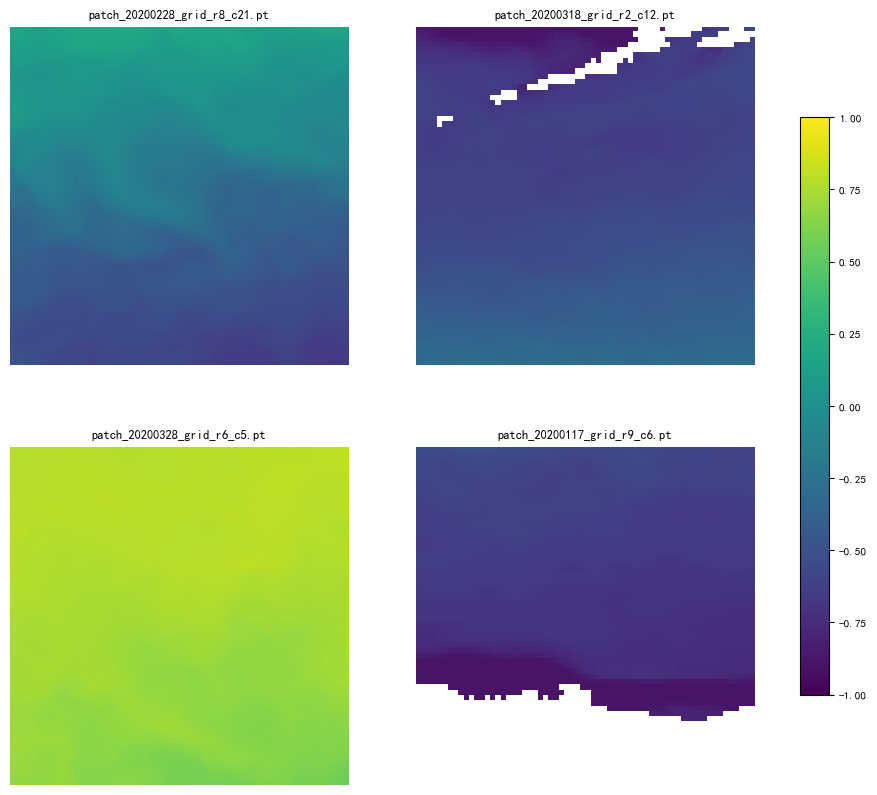

In [52]:
# @title Part 2.A: 时间划分与 Patch 生成、保存

import os
import shutil
import numpy as np
import pandas as pd # 确保 pandas 已导入
import torch
import xarray as xr # 确保 xarray 已导入
from tqdm.auto import tqdm # 确保 tqdm 已导入
import glob # 确保 glob 已导入
import matplotlib.pyplot as plt # 确保 matplotlib 已导入


# --- 关键参数 ---

PATCH_SIZE = 64
STRIDE = 64 # 非重叠 patch
NAN_THRESHOLD = 0.75

# --- 输出目录定义 ---
PATCH_DIR = "../data/processed/ERA5/patches" # 基础目录

def patches(sst_data_array,patch_size,stride,nan_threshold_elemental, output_dir):
    print("开始生成并保存元素 Patch (每日切割)...")
    num_time, H, W = sst_data_array.shape
    saved_elemental_patch_count = 0

    for t_idx in tqdm(range(num_time), desc="处理每日SST图"):
        daily_map_np = sst_data_array.isel(time=t_idx).values # 当天的完整地图 [H,W]
        
        try:
            time_coord = sst_data_array.time[t_idx].values
            if not np.issubdtype(time_coord.dtype, np.datetime64):
                time_coord = np.datetime64(str(time_coord))
            current_date_str = pd.Timestamp(time_coord).strftime('%Y%m%d')
        except Exception as e:
            print(f"警告：无法从时间坐标 {sst_data_array.time[t_idx].values} 获取日期字符串: {e}。将使用索引代替。")
            current_date_str = f"dayidx{t_idx}"

        for r_start in range(0, H - patch_size + 1, stride):
            for c_start in range(0, W - patch_size + 1, stride):
                elemental_patch_np = daily_map_np[r_start : r_start + patch_size,
                                                  c_start : c_start + patch_size] # 形状 [64,64]
                
                # 对当前这个 (64,64) 的元素 patch 进行 NaN 过滤
                if np.isnan(elemental_patch_np).sum() / elemental_patch_np.size > nan_threshold_elemental:
                    continue # 跳过这个元素 patch，不保存

                elemental_patch_torch = torch.from_numpy(elemental_patch_np.copy()).float()
                
                grid_row_idx = r_start // stride
                grid_col_idx = c_start // stride
                
                filename = f"patch_{current_date_str}_grid_r{grid_row_idx}_c{grid_col_idx}.pt"
                filepath = os.path.join(output_dir, filename)
                
                torch.save(elemental_patch_torch, filepath) # 直接保存 (64,64) 的张量
                saved_elemental_patch_count += 1
                
    print(f"Patches 生成完毕。共保存了 {saved_elemental_patch_count} 个 patch 文件到 '{output_dir}'。")
    return saved_elemental_patch_count    

# 随机可视化四个训练集 patch 的示例
def visualize_patch_example(patch_dir):
    patch_files = sorted(glob.glob(os.path.join(patch_dir, "*.pt")))
    if not patch_files:
        print("没有找到任何 Patch 文件。请先生成 Patch。")
        return
    
    example_patches = np.random.choice(patch_files, size=4, replace=False)
    fig, axes = plt.subplots(2, 2, figsize=(12,10))
    ims = []  

    for ax, patch_file in zip(axes.flatten(), example_patches):
        patch_tensor = torch.load(patch_file)
        im = ax.imshow(patch_tensor.numpy(), cmap='viridis', vmin=-1, vmax=1)
        ims.append(im)
        ax.set_title(f"{os.path.basename(patch_file)}", fontsize=9)
        ax.axis('off')

    # 添加一个共用的 colorbar
    cbar = fig.colorbar(ims[0], ax=axes.ravel().tolist(), shrink=0.75, orientation='vertical')
    cbar.ax.tick_params(labelsize=8)

    plt.show()

DO_PATCHING = False # 设置为 True 以生成和保存 Patches

if DO_PATCHING:
    # --- 创建输出目录 (如果存在则先删除) ---
    if os.path.exists(PATCH_DIR):
        print(f"警告: 输出目录 '{PATCH_DIR}' 已存在，将删除并重新创建。")
        shutil.rmtree(PATCH_DIR)
    os.makedirs(PATCH_DIR, exist_ok=True)
    print(f"已创建输出目录: {PATCH_DIR}")

    print("\n--- 开始生成和保存 Patches ---")
    total_patches = patches(sst_normalized, PATCH_SIZE, STRIDE, NAN_THRESHOLD, PATCH_DIR)
    print(f"\n--- 完成 Patch 生成 --- 共生成 {total_patches} 个 Patch 文件。")
else:
    print("\n--- 跳过 Patch 生成 ---")
    print("请设置 DO_PATCHING = True 来生成和保存 Patches。")
    print(f"共有 {len(glob.glob(os.path.join(PATCH_DIR, '*.pt')))} 个 Patch 文件已存在。")

# 可视化一个 Patch 示例
visualize_patch_example(PATCH_DIR)
    

 创建 PyTorch Dataset 以加载已保存的 Patch，并创建 DataLoader 

In [ ]:
# @title Part 2.B (新思路): 创建 Dataset 以动态加载和组合序列
# @markdown 运行此单元以定义新的 Dataset 类，并创建 DataLoader。

import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import os
import glob
import pandas as pd # 确保 pandas 已导入
import matplotlib.pyplot as plt # 确保 matplotlib 已导入

# # --- 确保关键参数已定义 ---
# # PATCH_DIR (来自 Part 2.A)
# # sst_normalized (用于获取时间坐标和原始数据信息)
# # SEQUENCE_LEN, PATCH_SIZE, STRIDE, NUM_TEST_TARGET_DAYS (用于定义序列和划分)
# # NAN_THRESHOLD (这个现在是用于评估序列中的目标 patch 是否有效)

# if 'PATCH_DIR' not in globals() or not os.path.exists(PATCH_DIR):
#     print(f"错误：元素 Patch 目录 '{PATCH_DIR}' 不存在。请先运行 Part 2.A。")
#     raise SystemExit("元素 Patch 目录未准备好。")
# if 'sst_normalized' not in globals(): raise SystemExit("sst_normalized 未定义")
# if 'SEQUENCE_LEN' not in globals(): SEQUENCE_LEN = 30
# if 'PATCH_SIZE' not in globals(): PATCH_SIZE = 64
# if 'STRIDE' not in globals(): STRIDE = 64
# if 'NUM_TEST_TARGET_DAYS' not in globals(): NUM_TEST_TARGET_DAYS = 3
# if 'NAN_THRESHOLD' not in globals(): NAN_THRESHOLD = 0.75 # 用于序列的目标patch


# --- 时间划分逻辑 (用于确定目标日索引) ---
num_total_time_steps = sst_normalized.shape[0]
# 训练集的目标日绝对索引列表
train_target_day_abs_indices = list(range(SEQUENCE_LEN, num_total_time_steps - NUM_TEST_TARGET_DAYS))
# 测试集的目标日绝对索引列表
test_target_day_abs_indices = list(range(num_total_time_steps - NUM_TEST_TARGET_DAYS, num_total_time_steps))

print(f"规划的训练集目标日绝对索引范围: {min(train_target_day_abs_indices)}-{max(train_target_day_abs_indices)} (共{len(train_target_day_abs_indices)}天)")
if test_target_day_abs_indices:
    print(f"规划的测试集目标日绝对索引范围: {min(test_target_day_abs_indices)}-{max(test_target_day_abs_indices)} (共{len(test_target_day_abs_indices)}天)")
else:
    print("警告：测试集目标日为空。")


class DynamicSequenceDataset(Dataset):
    def __init__(self, elemental_patch_dir, sst_time_coords,
                 list_of_target_day_abs_indices_for_split, 
                 sequence_len, patch_size, stride, H_full, W_full,
                 nan_threshold_sequence_target):
        self.elemental_patch_dir = elemental_patch_dir
        self.sst_time_coords = sst_time_coords # xarray time coordinates
        self.list_of_target_day_abs_indices = list_of_target_day_abs_indices_for_split
        self.sequence_len = sequence_len
        self.patch_size = patch_size
        self.stride = stride
        self.H_full, self.W_full = H_full, W_full
        self.nan_threshold_sequence_target = nan_threshold_sequence_target
        
        self.valid_samples = [] # 存储 (target_day_abs_idx, r_grid, c_grid, target_date_str)
        self._prepare_valid_samples()

    def _get_elemental_patch_filepath(self, abs_time_idx, r_grid, c_grid):
        try:
            time_coord = self.sst_time_coords[abs_time_idx].values
            if not np.issubdtype(time_coord.dtype, np.datetime64):
                time_coord = np.datetime64(str(time_coord))
            date_str = pd.Timestamp(time_coord).strftime('%Y%m%d')
        except Exception:
            date_str = f"dayidx{abs_time_idx}" # 回退方案
        
        filename = f"patch_{date_str}_grid_r{r_grid}_c{c_grid}.pt"
        return os.path.join(self.elemental_patch_dir, filename)

    def _prepare_valid_samples(self):
        print(f"正在为数据集准备有效的序列样本定义 (可能需要一些时间)...")
        num_r_grids = (self.H_full - self.patch_size) // self.stride + 1
        num_c_grids = (self.W_full - self.patch_size) // self.stride + 1

        for target_abs_idx in tqdm(self.list_of_target_day_abs_indices, desc="检查有效序列"):
            # 1. 检查目标元素patch文件是否存在并满足NaN阈值
            target_patch_valid = False
            temp_loaded_target_patch_np = None # 用于 NaN 检查

            for r_grid in range(num_r_grids):
                for c_grid in range(num_c_grids):
                    target_patch_filepath = self._get_elemental_patch_filepath(target_abs_idx, r_grid, c_grid)
                    
                    if not os.path.exists(target_patch_filepath):
                        continue # 目标元素patch文件不存在，此位置无效

                    try: # 尝试加载目标patch以检查NaN
                        patch_data_np = torch.load(target_patch_filepath).numpy() # [64,64]
                        if np.isnan(patch_data_np).sum() / patch_data_np.size > self.nan_threshold_sequence_target:
                            continue # 序列的目标patch NaN过多
                        temp_loaded_target_patch_np = patch_data_np # 存储，后面可能用到
                        target_patch_valid_for_this_loc = True
                    except Exception:
                        continue # 加载失败

                    # 2. 检查所有30个输入元素patch文件是否存在
                    all_inputs_exist = True
                    for k in range(self.sequence_len):
                        input_abs_idx = target_abs_idx - self.sequence_len + k
                        input_patch_filepath = self._get_elemental_patch_filepath(input_abs_idx, r_grid, c_grid)
                        if not os.path.exists(input_patch_filepath):
                            all_inputs_exist = False
                            break
                    
                    if target_patch_valid_for_this_loc and all_inputs_exist:
                        # 获取目标日期字符串
                        try:
                            time_coord = self.sst_time_coords[target_abs_idx].values
                            if not np.issubdtype(time_coord.dtype, np.datetime64): time_coord = np.datetime64(str(time_coord))
                            target_date_str_for_sample = pd.Timestamp(time_coord).strftime('%Y%m%d')
                        except: target_date_str_for_sample = f"dayidx{target_abs_idx}"
                        
                        self.valid_samples.append({
                            "target_day_abs_idx": target_abs_idx,
                            "r_grid": r_grid,
                            "c_grid": c_grid,
                            "target_date_str": target_date_str_for_sample,
                            "abs_coords": (r_grid * self.stride, c_grid * self.stride) # 绝对像素起始
                        })
        print(f"有效序列样本定义准备完毕，共找到 {len(self.valid_samples)} 个样本。")


    def __len__(self):
        return len(self.valid_samples)

    def __getitem__(self, idx):
        sample_def = self.valid_samples[idx]
        target_abs_idx = sample_def["target_day_abs_idx"]
        r_grid = sample_def["r_grid"]
        c_grid = sample_def["c_grid"]

        input_patches_list = []
        for k in range(self.sequence_len):
            input_abs_idx = target_abs_idx - self.sequence_len + k
            filepath = self._get_elemental_patch_filepath(input_abs_idx, r_grid, c_grid)
            patch_2d = torch.load(filepath) # [64,64]
            patch_3d = patch_2d.unsqueeze(0) # [1,64,64] (C,H,W)
            input_patches_list.append(torch.nan_to_num(patch_3d, nan=0.0))
        
        input_patches_stacked = torch.stack(input_patches_list, dim=0) # [SeqLen, 1, H, W]

        target_filepath = self._get_elemental_patch_filepath(target_abs_idx, r_grid, c_grid)
        target_patch_2d = torch.load(target_filepath) # [64,64]
        target_patch_stacked = torch.nan_to_num(target_patch_2d.unsqueeze(0), nan=0.0) # [1,1,H,W]

        return {
            "input_patches": input_patches_stacked.squeeze(1), # [SeqLen, H, W] - 与UNet输入(拼接后30通道)匹配
            "target_patch": target_patch_stacked,             # [1, 1, H, W]
            "coords": (r_grid, c_grid),
            "abs_coords": sample_def["abs_coords"],
            "target_date": sample_def["target_date_str"],
            "target_time_idx_original": target_abs_idx
        }

# --- 创建 Dataset 实例 ---
H_full_map, W_full_map = sst_normalized.shape[1], sst_normalized.shape[2] # 720, 1440

print("\n--- 创建训练集 Dataset ---")
train_dataset_new = DynamicSequenceDataset(
    PATCH_DIR, sst_normalized.time, train_target_day_abs_indices,
    SEQUENCE_LEN, PATCH_SIZE, STRIDE, H_full_map, W_full_map, NAN_THRESHOLD
)

print("\n--- 创建测试集 Dataset ---")
test_dataset_new = None
if test_target_day_abs_indices:
    test_dataset_new = DynamicSequenceDataset(
        PATCH_DIR, sst_normalized.time, test_target_day_abs_indices,
        SEQUENCE_LEN, PATCH_SIZE, STRIDE, H_full_map, W_full_map, NAN_THRESHOLD
    )
else:
    print("测试集目标日列表为空，不创建测试 Dataset。")

# --- 创建 DataLoader 实例 ---
BATCH_SIZE = 16
train_dataloader_new = None
test_dataloader_new = None

if len(train_dataset_new) > 0:
    print(f"训练集样本数 : {len(train_dataset_new)}")
    train_dataloader_new = DataLoader(train_dataset_new, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True) # num_workers=0 优先保证能跑通
else:
    print("训练集为空，不创建 DataLoader。")

if test_dataset_new and len(test_dataset_new) > 0:
    print(f"测试集样本数: {len(test_dataset_new)}")
    test_dataloader_new = DataLoader(test_dataset_new, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
else:
    print("测试集为空或未创建，不创建 DataLoader。")

# --- 验证 DataLoader 输出并可视化 (以训练集为例) ---
if train_dataloader_new and len(train_dataset_new) > 0:
    print("\n--- 检查训练 DataLoader 输出---")
    try:
        sample_batch_new = next(iter(train_dataloader_new))
        print(f"输入 patches 批次形状: {sample_batch_new['input_patches'].shape}") # 期望 [B, SeqLen, H, W]
        print(f"目标 patch 批次形状: {sample_batch_new['target_patch'].shape}")   # 期望 [B, 1, 1, H, W] or [B,1,H,W]
        print(f"目标日期示例: {sample_batch_new['target_date'][0]}")

        # 可视化一个样本
        idx_to_show = 0
        # input_patches 是 [B, SeqLen, H, W], 取第一帧可视化
        input_sample_vis = sample_batch_new['input_patches'][idx_to_show, 0, :, :].cpu().numpy()
        # target_patch 是 [B, 1, 1, H, W] 或 [B,1,H,W], 取 [0,0,:,:] 或 [0,:,:]
        target_sample_vis = sample_batch_new['target_patch'][idx_to_show].squeeze(0).cpu().numpy() # [1,H,W] or [H,W]
        if target_sample_vis.ndim == 3 and target_sample_vis.shape[0] == 1: # 如果是 [1,H,W]
            target_sample_vis = target_sample_vis.squeeze(0) # 变为 [H,W]

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        # ... (可视化代码，与之前类似，确保正确索引和显示)
        axes[0].imshow(input_sample_vis, cmap='viridis', vmin=-1, vmax=1)
        axes[0].set_title(f"训练样本输入 (序列第0天)\n日期(目标): {sample_batch_new['target_date'][idx_to_show]}")
        im = axes[1].imshow(target_sample_vis, cmap='viridis', vmin=-1, vmax=1)
        axes[1].set_title(f"训练样本目标 (预测日)\n日期: {sample_batch_new['target_date'][idx_to_show]}")
        fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.046, pad=0.08)
        plt.tight_layout()
        plt.show()

    except StopIteration:
        print("训练 DataLoader 为空或无法获取样本。")
    except Exception as e:
        print(f"可视化时发生错误 : {e}")
else:
    print("训练 DataLoader  未创建或训练集为空，跳过可视化。")

规划的训练集目标日绝对索引范围: 30-87 (共58天)
规划的测试集目标日绝对索引范围: 88-90 (共3天)

--- 创建训练集 Dataset ---
正在为数据集准备有效的序列样本定义 (可能需要一些时间)...


检查有效序列:   0%|          | 0/58 [00:00<?, ?it/s]

阶段三：模型定义 (UNet)

In [33]:
import torch
from diffusers import UNet2DModel

# --- 确保关键参数已定义 (通常来自之前的阶段或配置文件) ---
if 'PATCH_SIZE' not in globals():
    PATCH_SIZE = 64 # 如果未定义，则使用默认值
    print(f"警告: PATCH_SIZE 未找到，使用默认值 {PATCH_SIZE}")

# --- UNet 模型配置 ---
model_config = {
    "sample_size": PATCH_SIZE,  # 目标 patch 的尺寸
    "in_channels": 1 + SEQUENCE_LEN,  # 1 (带噪声的目标patch) + 30 (历史条件patch) = 31
    "out_channels": 1,  # 模型预测单通道噪声
    "layers_per_block": 2,  # 每个U-Net块中的ResNet层数
    "block_out_channels": (32, 64, 128, 256),  # 各U-Net块的输出通道数 (可调整)
                                                # 调整为 (64, 128, 256, 256) 稍微减小了最后一层的大小，更适合64x64
    "down_block_types": (
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    ),
    "up_block_types": (
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
}

# --- 实例化 UNet2DModel ---
model = UNet2DModel(**model_config)

# --- 打印模型信息 ---
print(f"UNet2DModel 实例化成功:")
# print(model) # 打印模型结构会很长，可以选择性注释掉

# 计算并打印模型参数量
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"模型总参数量: {num_params / 1e6:.2f} M")

# --- 简单测试模型前向传播 (可选) ---
# 这有助于捕获配置错误
try:
    print("\n尝试进行一次模型前向传播测试...")
    batch_size_test = 2 # 模拟小批量
    test_noisy_patch = torch.randn(batch_size_test, 1, PATCH_SIZE, PATCH_SIZE)
    test_condition_patches = torch.randn(batch_size_test, SEQUENCE_LEN, PATCH_SIZE, PATCH_SIZE)
    
    # 拼接输入
    test_model_input = torch.cat([test_noisy_patch, test_condition_patches], dim=1)
    
    # 模拟时间步长 (通常是一个整数张量)
    test_timesteps = torch.randint(0, 1000, (batch_size_test,)).long()
    
    # 前向传播
    with torch.no_grad(): # 不需要计算梯度
        prediction = model(sample=test_model_input, timestep=test_timesteps).sample
        
    print(f"测试输入形状: {test_model_input.shape}")       # 预期: [B, 31, PatchH, PatchW]
    print(f"测试时间步长形状: {test_timesteps.shape}")   # 预期: [B]
    print(f"测试输出形状: {prediction.shape}")           # 预期: [B, 1, PatchH, PatchW]
    
    if prediction.shape == (batch_size_test, 1, PATCH_SIZE, PATCH_SIZE):
        print("模型前向传播测试成功！输出形状符合预期。")
    else:
        print(f"错误：模型输出形状 {prediction.shape} 与预期不符！")
        
except Exception as e:
    print(f"模型前向传播测试失败: {e}")
    print("请检查模型配置和输入数据的维度。")

# --- 关于设备选择的说明 ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device) # 这一步通常在训练设置阶段完成
# print(f"\n模型将尝试在 {device} 上运行 (实际移动到设备在训练阶段进行)。")

UNet2DModel 实例化成功:
模型总参数量: 14.17 M

尝试进行一次模型前向传播测试...
测试输入形状: torch.Size([2, 31, 64, 64])
测试时间步长形状: torch.Size([2])
测试输出形状: torch.Size([2, 1, 64, 64])
模型前向传播测试成功！输出形状符合预期。


阶段四：训练设置与训练循环

In [34]:

import torch
import torch.nn.functional as F
from diffusers import DDPMScheduler
from tqdm.auto import tqdm 



# --- 训练配置 ---
NUM_EPOCHS = 50  # @param {type:"integer"} 训练的总轮数 (对于预实验，可以先设小一点，如3-5)
LEARNING_RATE = 1e-4  # @param {type:"number"} 学习率
DDPM_NUM_TRAIN_TIMESTEPS = 1000  # 扩散过程的训练时间步数
DDPM_BETA_SCHEDULE = "linear"  # beta值的调度策略 (可选 "linear", "cosine", "squaredcos_cap_v2")
OUTPUT_DIR = "../checkpoint" # 模型检查点等输出的目录
SAVE_EPOCH_FREQ = 10 # 每隔多少个epoch保存一次模型，设为0则不保存中间模型

# 创建输出目录
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"模型输出将保存到: {OUTPUT_DIR}")

# --- 设备选择 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"将使用设备: {device}")

# --- 初始化 DDPMScheduler ---
noise_scheduler = DDPMScheduler(
    num_train_timesteps=DDPM_NUM_TRAIN_TIMESTEPS,
    beta_schedule=DDPM_BETA_SCHEDULE
)

# --- 将模型移动到设备 ---
model.to(device)

# --- 设置优化器 ---
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# --- 用于存储每个 epoch 的损失 ---
epoch_losses = []

# --- 开始训练循环 ---
print(f"\n--- 开始训练，共 {NUM_EPOCHS} 轮 ---")

for epoch in range(NUM_EPOCHS):
    model.train() # 设置模型为训练模式
    total_loss = 0.0
    
    # 使用 tqdm 创建进度条
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)
    
    for step, batch in enumerate(progress_bar):
        # 1. 将数据移动到设备
        try:
            # target_patch 是清晰的目标图像 [B, 1, H, W]
            clean_images = batch['target_patch'].to(device)
            # input_patches 是条件输入 (历史30天) [B, 30, H, W]
            conditional_input = batch['input_patches'].to(device)
        except Exception as e:
            print(f"错误：无法从批次中获取数据或将其移动到设备: {e}")
            print(f"批次数据键: {batch.keys() if isinstance(batch, dict) else '非字典类型'}")
            continue # 跳过这个批次

        # 确保批次大小大于0
        if clean_images.shape[0] == 0:
            continue

        # 2. 采样噪声 (epsilon)
        #    噪声与清晰图像具有相同的形状
        noise = torch.randn_like(clean_images)

        # 3. 采样随机时间步长 (t)
        #    为批次中的每个样本采样一个时间步长
        batch_size = clean_images.shape[0]
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (batch_size,), device=device
        ).long()

        # 4. 根据噪声和时间步长，向清晰图像添加噪声 (扩散过程的前向步骤)
        #    noisy_images = x_t
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        
        # 5. 准备模型输入
        #    将带噪声的图像和条件输入沿通道维度拼接
        #    noisy_images: [B, 1, H, W]
        #    conditional_input: [B, 30, H, W]
        #    model_input: [B, 31, H, W]
        model_input = torch.cat([noisy_images, conditional_input], dim=1)

        # 6. 获取模型的预测 (预测噪声)
        noise_pred = model(sample=model_input, timestep=timesteps, return_dict=False)[0]
        # .sample 是旧版diffusers的用法, 新版直接返回值或者一个元组，第一个元素是sample
        # 如果 model(...) 返回的是 BaseModelOutputWithLatents，则应为 model(...).sample
        # 如果是元组，通常第一个元素是预测结果。UNet2DModel默认返回 (sample,)

        # 7. 计算损失
        #    损失是模型预测的噪声与原始添加的噪声之间的均方误差
        loss = F.mse_loss(noise_pred, noise)

        # 8. 反向传播和优化
        optimizer.zero_grad() # 清除之前的梯度
        loss.backward()       # 计算梯度
        optimizer.step()      # 更新模型参数

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"}) # 更新进度条上的损失显示
    
    progress_bar.close() # 确保当前 epoch 的进度条关闭
    avg_epoch_loss = total_loss / len(train_dataloader)
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} 完成 - 平均损失: {avg_epoch_loss:.4f}")

    # (可选) 保存模型检查点
    if SAVE_EPOCH_FREQ > 0 and (epoch + 1) % SAVE_EPOCH_FREQ == 0:
        checkpoint_path = os.path.join(OUTPUT_DIR, f"model_epoch_{epoch+1}.pt")
        # 可以只保存模型状态字典，也可以保存整个模型，或包含优化器状态等
        # 为了简单起见，这里只保存模型状态字典
        torch.save(model.state_dict(), checkpoint_path)
        print(f"模型检查点已保存到: {checkpoint_path}")

print("\n--- 训练完成 ---")

# 训练结束后，可以保存最终的模型
final_model_path = os.path.join(OUTPUT_DIR, "model_final.pt")
torch.save(model.state_dict(), final_model_path)
print(f"最终模型已保存到: {final_model_path}")

# 可视化训练损失
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), epoch_losses, marker='o', linestyle='-', color='b')
plt.title("训练损失变化", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("平均损失", fontsize=14)
plt.xticks(range(1, NUM_EPOCHS + 1), fontsize=12)
plt.grid()
plt.show()

模型输出将保存到: ../checkout
将使用设备: cuda

--- 开始训练，共 50 轮 ---


Epoch 1/50:   0%|          | 0/10585 [00:00<?, ?it/s]

Epoch 1/50 完成 - 平均损失: 0.0063


Epoch 2/50:   0%|          | 0/10585 [00:00<?, ?it/s]

Epoch 2/50 完成 - 平均损失: 0.0015


Epoch 3/50:   0%|          | 0/10585 [00:00<?, ?it/s]

Epoch 3/50 完成 - 平均损失: 0.0014


Epoch 4/50:   0%|          | 0/10585 [00:00<?, ?it/s]

Epoch 4/50 完成 - 平均损失: 0.0012


Epoch 5/50:   0%|          | 0/10585 [00:00<?, ?it/s]

Epoch 5/50 完成 - 平均损失: 0.0010


Epoch 6/50:   0%|          | 0/10585 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 阶段五：推理与评估

评估结果将保存到: ../checkout\evaluation_results
推理将使用设备: cuda
模型权重已从 '../checkout\model_final.pt' 加载，并设置为评估模式。

--- 开始在测试集上进行自回归预测 (共 3 天) ---
收集测试集初始输入序列...


收集初始序列:   0%|          | 0/37 [00:00<?, ?it/s]

共找到 194 个独特的 patch 位置进行自回归预测。


自回归预测各Patch位置:   0%|          | 0/194 [00:00<?, ?it/s]


--- 开始重建预测的SST图 ---


重建每日SST图:   0%|          | 0/3 [00:00<?, ?it/s]


--- 开始评估预测结果 ---


计算评估指标:   0%|          | 0/3 [00:00<?, ?it/s]

  目标日 2020-03-29 (索引 88): RMSE = nan, MAE = nan
  目标日 2020-03-30 (索引 89): RMSE = nan, MAE = nan
  目标日 2020-03-31 (索引 90): RMSE = nan, MAE = nan
对比图已保存到: ../checkout\evaluation_results\sst_comparison_2020-03-29.png


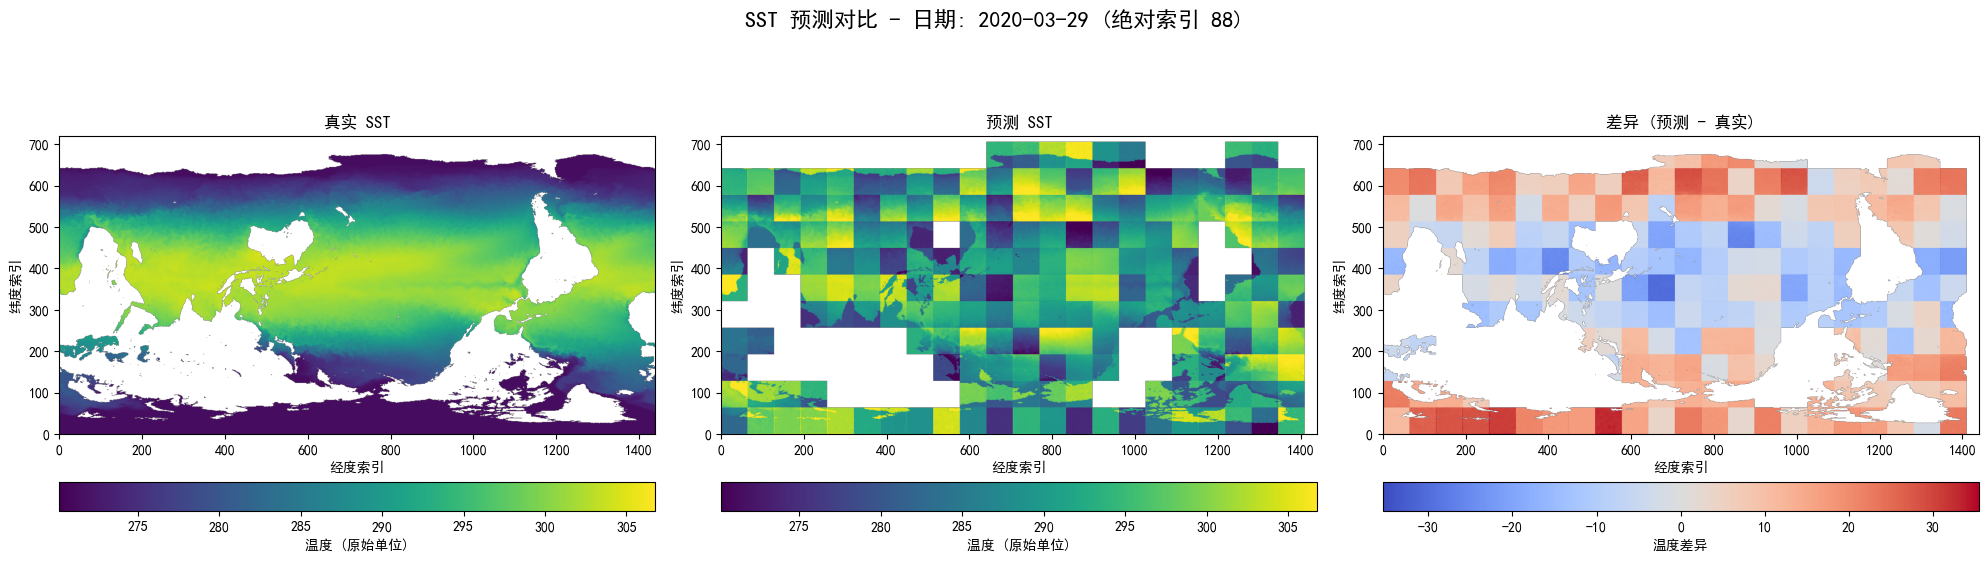


--- 推理与评估完成 ---


In [ ]:
# @title Phase 5: 推理与评估
# @markdown 运行此单元以加载训练好的模型，在测试集上进行预测，并评估结果。

import torch
from diffusers import DDPMScheduler # 确保 DDPMScheduler 已导入
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import xarray as xr # 确保 xarray 已导入
import matplotlib.pyplot as plt
import os


# --- 推理配置 ---
MODEL_PATH = os.path.join(OUTPUT_DIR, "model_final.pt") # 或选择特定的 epoch 模型
NUM_INFERENCE_STEPS = 100 # @param {type:"integer"} DDIM/DDPM 推理步数 (例如 50-200)
# DDPM_NUM_TRAIN_TIMESTEPS 和 DDPM_BETA_SCHEDULE 应与训练时一致

EVALUATION_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "evaluation_results")
os.makedirs(EVALUATION_OUTPUT_DIR, exist_ok=True)
print(f"评估结果将保存到: {EVALUATION_OUTPUT_DIR}")

# --- 设备选择 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"推理将使用设备: {device}")

# --- 1. 加载训练好的模型权重 ---
if not os.path.exists(MODEL_PATH):
    print(f"错误: 模型文件 '{MODEL_PATH}' 未找到。请确保模型已训练并保存。")
    raise SystemExit("模型文件未找到。")

# 重新实例化模型结构 (如果 model 对象不再内存中)
# model = UNet2DModel(**model_config) # model_config 需与训练时一致 (已在 Phase 3 定义)
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
except RuntimeError as e:
    print(f"加载模型状态字典时发生错误: {e}")
    print("这可能是因为当前 'model' 的结构与保存的权重不匹配。")
    print("请确保在 Phase 3 中定义的 'model_config' 与训练时使用的配置一致。")
    raise
model.to(device)
model.eval() # 设置模型为评估模式 (关闭 dropout, batchnorm 更新等)
print(f"模型权重已从 '{MODEL_PATH}' 加载，并设置为评估模式。")

# --- 初始化用于推理的 DDPMScheduler ---
# 注意：scheduler 的配置应与训练时使用的 DDPMScheduler 实例的配置匹配
inference_scheduler = DDPMScheduler(
    num_train_timesteps=DDPM_NUM_TRAIN_TIMESTEPS,
    beta_schedule=DDPM_BETA_SCHEDULE
)
inference_scheduler.set_timesteps(NUM_INFERENCE_STEPS) # 为推理设置具体的步数和时间表

# --- 2. 单 Patch 预测函数 ---
@torch.no_grad() # 推理时不需要计算梯度
def predict_single_patch(conditional_input_patch_seq, model, scheduler, device):
    """
    Args:
        conditional_input_patch_seq (Tensor): 形状 [1, SEQUENCE_LEN, H, W], 作为条件的过去N天patch序列
        model (torch.nn.Module): 训练好的UNet模型
        scheduler (DDPMScheduler): 配置好的扩散调度器
        device (torch.device): 运行设备
    Returns:
        Tensor: 预测的清晰patch, 形状 [1, 1, H, W]
    """
    H, W = conditional_input_patch_seq.shape[-2:]
    
    # 1. 初始化随机噪声作为去噪起点 x_T
    noisy_sample = torch.randn(1, 1, H, W, device=device) # 注意通道为1，因为这是我们要去噪的目标
    
    # 确保条件输入在正确的设备上
    conditional_input_patch_seq = conditional_input_patch_seq.to(device)

    # 2. 迭代去噪循环
    for t in tqdm(scheduler.timesteps, desc="单Patch去噪", leave=False, disable=True): # 可以禁用内部tqdm
        # 准备模型输入: [带噪声的样本, 条件]
        model_input = torch.cat([noisy_sample, conditional_input_patch_seq], dim=1)
        
        # 确保当前时间步 't' 在传递给模型前，与模型在同一个设备上
        timestep_on_device = t.to(device).unsqueeze(0)  

        # 模型预测噪声
        noise_pred = model(sample=model_input, timestep=timestep_on_device).sample # timestep可能需要unsqueeze(0)
        
        # 使用调度器执行一步去噪
        noisy_sample = scheduler.step(noise_pred, t, noisy_sample).prev_sample
        
    return noisy_sample # 返回去噪后的清晰patch

# --- 3. 自回归预测未来3天 ---
# 我们需要遍历 test_dataset 来获取每个 patch 位置的初始输入序列
# 然后进行自回归预测。
# 结果将存储在 all_predicted_patches[target_day_abs_idx][(r_start, c_start)] = predicted_patch_tensor

all_predicted_patches = {} # key: target_day_abs_idx (在sst_normalized中的绝对时间索引)
                           # value: dict -> key: (r_start, c_start), value: 预测的patch张量 [1,1,H,W]

if test_dataloader is not None and len(test_dataloader.dataset) > 0:
    print(f"\n--- 开始在测试集上进行自回归预测 (共 {NUM_TEST_TARGET_DAYS} 天) ---")
    
    # 遍历测试数据集中的每个初始样本
    # 每个样本代表一个特定 (patch位置, 初始30天输入) -> 目标是预测第1个测试日
    # 我们需要确保test_dataloader的shuffle=False，以便能够按顺序或可识别地处理
    
    # 为了按patch位置组织预测，我们先收集所有独特的patch位置和它们的初始输入
    initial_patch_inputs = {} # key: (r_start, c_start), value: dict {target_time_idx_original: initial_30_day_sequence}
    
    print("收集测试集初始输入序列...")
    for batch in tqdm(test_dataloader, desc="收集初始序列"):
        abs_coords_rows = batch['abs_coords'][0].tolist()
        abs_coords_cols = batch['abs_coords'][1].tolist()
        initial_sequences = batch['input_patches'] # [B, 30, H, W]
        target_indices_original = batch['target_time_idx_original'].tolist()

        for i in range(initial_sequences.shape[0]):
            r, c = abs_coords_rows[i], abs_coords_cols[i]
            target_idx = target_indices_original[i] # 这是第一个测试目标日的索引
            if (r,c) not in initial_patch_inputs or target_idx < initial_patch_inputs[(r,c)]['target_time_idx_original']:
                 initial_patch_inputs[(r,c)] = {
                     "sequence": initial_sequences[i:i+1], # [1, 30, H, W]
                     "target_time_idx_original": target_idx # 第一个预测目标的绝对时间索引
                 }
    
    print(f"共找到 {len(initial_patch_inputs)} 个独特的 patch 位置进行自回归预测。")

    for patch_coords, data in tqdm(initial_patch_inputs.items(), desc="自回归预测各Patch位置"):
        r_start, c_start = patch_coords
        current_input_sequence = data['sequence'].clone().to(device) # [1, 30, H, W]
        first_target_day_abs_idx = data['target_time_idx_original']

        for day_offset in range(NUM_TEST_TARGET_DAYS): # 预测 0, 1, 2 天 (即 TestDay1, TestDay2, TestDay3)
            target_day_abs_idx_to_predict = first_target_day_abs_idx + day_offset
            
            # print(f"  预测 Patch ({r_start},{c_start}) 的第 {day_offset+1} 个未来天 (绝对索引 {target_day_abs_idx_to_predict})...")
            predicted_patch = predict_single_patch(current_input_sequence, model, inference_scheduler, device) # [1, 1, H, W]
            
            # 存储预测结果
            if target_day_abs_idx_to_predict not in all_predicted_patches:
                all_predicted_patches[target_day_abs_idx_to_predict] = {}
            all_predicted_patches[target_day_abs_idx_to_predict][(r_start, c_start)] = predicted_patch.cpu() # 存回CPU

            # 更新输入序列用于下一次预测 (如果不是最后一天)
            if day_offset < NUM_TEST_TARGET_DAYS - 1:
                # current_input_sequence: [1, 30, H, W]
                # predicted_patch: [1, 1, H, W]
                # 丢弃最老的帧，加入预测的帧
                current_input_sequence = torch.cat([current_input_sequence[:, 1:, :, :], predicted_patch], dim=1)
else:
    print("测试数据加载器为空或未定义，跳过推理步骤。")


# --- 4. 图像重建 ---
# sst_normalized 是 xr.DataArray, shape (time, lat, lon)
H_full, W_full = sst_normalized.shape[1], sst_normalized.shape[2]

reconstructed_predictions = {} # key: target_day_abs_idx, value: 重建的完整SST图 (numpy [H,W])

print(f"\n--- 开始重建预测的SST图 ---")
for target_day_abs_idx, patches_for_day in tqdm(all_predicted_patches.items(), desc="重建每日SST图"):
    # 创建一个空的完整地图 (填充NaN，以便只在patch区域有值)
    full_predicted_map = np.full((H_full, W_full), np.nan, dtype=np.float32)
    
    for (r_start, c_start), predicted_patch_tensor in patches_for_day.items():
        patch_numpy = predicted_patch_tensor.squeeze().numpy() # [H,W]
        full_predicted_map[r_start : r_start + PATCH_SIZE, 
                           c_start : c_start + PATCH_SIZE] = patch_numpy
                           
    reconstructed_predictions[target_day_abs_idx] = full_predicted_map


# --- 5. 评估 ---
# 反归一化函数
def unnormalize_data(normalized_data_np, s_min, s_max):
    return (normalized_data_np + 1) / 2.0 * (s_max - s_min) + s_min

s_min_val = normalization_params['min']
s_max_val = normalization_params['max']

evaluation_metrics = {} # key: target_day_abs_idx, value: {rmse: val, mae: val}
print(f"\n--- 开始评估预测结果 ---")

for target_day_abs_idx, predicted_map_norm in tqdm(reconstructed_predictions.items(), desc="计算评估指标"):
    # 获取真实SST图 (归一化状态)
    try:
        gt_map_norm_xr = sst_normalized.isel(time=target_day_abs_idx)
        gt_map_norm_np = gt_map_norm_xr.values # [H,W]
    except IndexError:
        print(f"错误：无法获取绝对时间索引 {target_day_abs_idx} 的真实SST图。超出范围。")
        continue

    # 反归一化预测图和真实图
    predicted_map_unnorm = unnormalize_data(predicted_map_norm, s_min_val, s_max_val)
    gt_map_unnorm = unnormalize_data(gt_map_norm_np, s_min_val, s_max_val)

    # 计算 RMSE 和 MAE，只在非NaN区域 (海洋区域)
    # 创建一个mask，NaN为False，非NaN为True
    valid_mask = ~np.isnan(gt_map_unnorm)
    
    if np.sum(valid_mask) == 0: # 如果真实图中没有有效数据点
        print(f"警告: 真实SST图 (索引 {target_day_abs_idx}) 全是NaN，无法计算指标。")
        rmse = np.nan
        mae = np.nan
    else:
        squared_errors = (predicted_map_unnorm[valid_mask] - gt_map_unnorm[valid_mask])**2
        absolute_errors = np.abs(predicted_map_unnorm[valid_mask] - gt_map_unnorm[valid_mask])
        
        rmse = np.sqrt(np.mean(squared_errors))
        mae = np.mean(absolute_errors)
        
    evaluation_metrics[target_day_abs_idx] = {"rmse": rmse, "mae": mae}
    target_date_str = pd.Timestamp(gt_map_norm_xr.time.values).strftime('%Y-%m-%d')
    print(f"  目标日 {target_date_str} (索引 {target_day_abs_idx}): RMSE = {rmse:.4f}, MAE = {mae:.4f}")


# --- 6. (可选) 可视化 ---
# 选择一个测试日进行可视化
if reconstructed_predictions and evaluation_metrics:
    # 选择第一个有评估结果的测试日进行可视化
    example_target_day_abs_idx = sorted(evaluation_metrics.keys())[0]
    
    predicted_map_norm_vis = reconstructed_predictions[example_target_day_abs_idx]
    gt_map_norm_vis = sst_normalized.isel(time=example_target_day_abs_idx).values
    
    # 反归一化用于可视化
    predicted_map_unnorm_vis = unnormalize_data(predicted_map_norm_vis, s_min_val, s_max_val)
    gt_map_unnorm_vis = unnormalize_data(gt_map_norm_vis, s_min_val, s_max_val)

    target_date_str_vis = pd.Timestamp(sst_normalized.time[example_target_day_abs_idx].values).strftime('%Y-%m-%d')

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f"SST 预测对比 - 日期: {target_date_str_vis} (绝对索引 {example_target_day_abs_idx})", fontsize=16)

    # 真实图
    im1 = axes[0].imshow(gt_map_unnorm_vis, cmap='viridis', origin='lower')
    axes[0].set_title("真实 SST")
    axes[0].set_xlabel("经度索引")
    axes[0].set_ylabel("纬度索引")
    fig.colorbar(im1, ax=axes[0], orientation='horizontal', pad=0.1, label='温度 (原始单位)')

    # 预测图
    im2 = axes[1].imshow(predicted_map_unnorm_vis, cmap='viridis', origin='lower', vmin=np.nanmin(gt_map_unnorm_vis), vmax=np.nanmax(gt_map_unnorm_vis))
    axes[1].set_title("预测 SST")
    axes[1].set_xlabel("经度索引")
    axes[1].set_ylabel("纬度索引")
    fig.colorbar(im2, ax=axes[1], orientation='horizontal', pad=0.1, label='温度 (原始单位)')

    # 差异图
    diff_map = predicted_map_unnorm_vis - gt_map_unnorm_vis
    # 找到一个合适的对称色标范围
    diff_max_abs = np.nanmax(np.abs(diff_map))
    im3 = axes[2].imshow(diff_map, cmap='coolwarm', origin='lower', vmin=-diff_max_abs if diff_max_abs >0 else -1, vmax=diff_max_abs if diff_max_abs > 0 else 1)
    axes[2].set_title("差异 (预测 - 真实)")
    axes[2].set_xlabel("经度索引")
    axes[2].set_ylabel("纬度索引")
    fig.colorbar(im3, ax=axes[2], orientation='horizontal', pad=0.1, label='温度差异')

    plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # 调整布局以适应主标题和色条
    
    # 保存图像
    vis_path = os.path.join(EVALUATION_OUTPUT_DIR, f"sst_comparison_{target_date_str_vis}.png")
    try:
        plt.savefig(vis_path)
        print(f"对比图已保存到: {vis_path}")
    except Exception as e:
        print(f"保存对比图失败: {e}")
    plt.show()
else:
    print("没有可供可视化的预测结果或评估指标。")

print("\n--- 推理与评估完成 ---")